## Importowanie bibliotek

In [61]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.src.layers import Dropout
from keras.src.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Załadowanie zmiennych

In [62]:
with open('data_dump/dataAnalysisVars.pkl', 'rb') as f:
    df = pickle.load(f)

    df_0 = pickle.load(f)
    df_mean = pickle.load(f)
    df_interpolate = pickle.load(f)

    normalized_std_0 = pickle.load(f)
    scaler_std_0 = pickle.load(f)

    normalized_std_mean = pickle.load(f)
    scaler_std_mean = pickle.load(f)

    normalized_std_interpolate = pickle.load(f)
    scaler_std_interpolate = pickle.load(f)

    normalized_minmax_0 = pickle.load(f)
    scaler_minmax_0 = pickle.load(f)

    normalized_minmax_mean = pickle.load(f)
    scaler_minmax_mean = pickle.load(f)

    normalized_minmax_interpolate = pickle.load(f)
    scaler_minmax_interpolate = pickle.load(f)

C:\Users\dkwap\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\dkwap\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\dkwap\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpi

## Funkcje do podziału zbioru danych

In [63]:
def split_df_train_test(data, test_size, seed):
    np.random.seed(seed)

    test_size = int(test_size * len(data))
    test_indices = np.random.choice(data.index, size=test_size, replace=False)
    train_indices = np.setdiff1d(data.index, test_indices)

    train_set = data.loc[train_indices]
    test_set = data.loc[test_indices]

    return train_set, test_set

def split_df_train_val_test(data, val_size, test_size, seed):
    np.random.seed(seed)

    val_size = int(val_size * len(data))
    test_size = int(test_size * len(data))

    val_test_indices = np.random.choice(data.index, size=val_size + test_size, replace=False)

    val_indices = val_test_indices[:val_size]
    test_indices = val_test_indices[val_size:]

    train_indices = np.setdiff1d(data.index, val_test_indices)

    train_set = data.loc[train_indices]
    val_set = data.loc[val_indices]
    test_set = data.loc[test_indices]

    return train_set, val_set, test_set

## SVM - Scikit-Learn

In [64]:
class SVMClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = SVC(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'C': [0.1, 1, 5, 10],
                'probability': [True, False],
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=8, cv=5, random_state=645, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 18 + ' SVM ' + '-' * 18)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc


## Random Forest - Scikit-Learn

In [65]:
class RandomForestClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = RandomForestClassifier(random_state=42)

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100, 150],
                'criterion': ['gini', 'entropy'],
                'bootstrap': [True, False]
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=12, cv=5, random_state=42, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 13 + ' Random Forest ' + '-' * 13)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc


### XGBoost

In [66]:
class XGBClassifierWrapper:

    def __init__(self, train_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.model = None
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = XGBClassifier(random_state=42, tree_method = "hist", device = "cuda")

    def train_model(self, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [3, 5, 10],
            }

        random_search = RandomizedSearchCV(self.model, param_distributions=param_grid, n_iter=6, cv=5, random_state=678, n_jobs=-1)
        random_search.fit(self.train_set, self.train_label)
        self.model = random_search.best_estimator_

    def evaluate_model(self):
        test_pred = self.model.predict(self.test_set)
        test_acc = accuracy_score(self.test_label, test_pred)
        print('-' * 16 + ' XGBoost ' + '-' * 16)
        for key, value in self.model.get_params().items():
            print(f"{key}: {value}")
        print('-' * 41)
        print('Test accuracy:', test_acc)
        print('-' * 41)
        return test_acc

## MLP - Keras

In [67]:
class MLPClassifierWrapper:

    def __init__(self, train_set, val_set, test_set):
        self.train_set = train_set.iloc[:, :-1]
        self.val_set = val_set.iloc[:, :-1]
        self.test_set = test_set.iloc[:, :-1]
        self.train_label = train_set.iloc[:, -1]
        self.val_label = val_set.iloc[:, -1]
        self.test_label = test_set.iloc[:, -1]
        self.history = None
        self._create_model()

    def _create_model(self):
        self.model = Sequential()

        self.model.add(Input(shape=(9,)))
        self.model.add(Dense(40, activation='leaky_relu'))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation='leaky_relu'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(20, activation='leaky_relu'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self):
        self.history = self.model.fit(self.train_set, self.train_label, epochs=150, batch_size=64, validation_data=(self.val_set, self.val_label))

    def evaluate_model(self):
        test_loss, test_acc = self.model.evaluate(self.test_set, self.test_label)
        print('-' * 18 + ' MLP ' + '-' * 18)
        print('Test accuracy:', test_acc)
        print('Test loss:', test_loss)
        print('-' * 41)
        return test_acc

    def plot_results(self):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()


## Trenowanie modeli

### Split danych

In [68]:
# Std zeros
train_std_0, test_std_0 = split_df_train_test(normalized_std_0, 0.2, 123)
train_std_mlp_0, val_std_mlp_0, test_std_mlp_0 = split_df_train_val_test(normalized_minmax_0, 0.1, 0.1, 111)

# Std mean
train_std_mean, test_std_mean = split_df_train_test(normalized_std_mean, 0.2, 123)
train_std_mlp_mean, val_std_mlp_mean, test_std_mlp_mean = split_df_train_val_test(normalized_std_mean, 0.1, 0.1, 111)

# Std interpolate
train_std_interpolate, test_std_interpolate = split_df_train_test(normalized_std_interpolate, 0.2, 123)
train_std_mlp_interpolate, val_std_mlp_interpolate, test_std_mlp_interpolate = split_df_train_val_test(normalized_std_interpolate, 0.1, 0.1, 111)

# Minmax zeros
train_minmax_0, test_minmax_0 = split_df_train_test(normalized_minmax_0, 0.2, 123)
train_minmax_mlp_0, val_minmax_mlp_0, test_minmax_mlp_0 = split_df_train_val_test(normalized_minmax_0, 0.1, 0.1, 111)

# Minmax mean
train_minmax_mean, test_minmax_mean = split_df_train_test(normalized_minmax_mean, 0.2, 123)
train_minmax_mlp_mean, val_minmax_mlp_mean, test_minmax_mlp_mean = split_df_train_val_test(normalized_minmax_mean, 0.1, 0.1, 111)

# Minmax interpolate
train_minmax_interpolate, test_minmax_interpolate = split_df_train_test(normalized_minmax_interpolate, 0.2, 123)
train_minmax_mlp_interpolate, val_minmax_mlp_interpolate, test_minmax_mlp_interpolate = split_df_train_val_test(normalized_minmax_interpolate, 0.1, 0.1, 111)

### Trenowanie SVM

In [69]:
# Std zeros
modelSVM_std_0 = SVMClassifierWrapper(train_std_0, test_std_0)
modelSVM_std_0.train_model()
accuracy_SVM_std_0 = modelSVM_std_0.evaluate_model()

# Std mean
modelSVM_std_mean = SVMClassifierWrapper(train_std_mean, test_std_mean)
modelSVM_std_mean.train_model()
accuracy_SVM_std_mean = modelSVM_std_mean.evaluate_model()

# Std interpolate
modelSVM_std_interpolate = SVMClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelSVM_std_interpolate.train_model()
accuracy_SVM_std_interpolate = modelSVM_std_interpolate.evaluate_model()

# Minmax zeros
modelSVM_minmax_0 = SVMClassifierWrapper(train_minmax_0, test_minmax_0)
modelSVM_minmax_0.train_model()
accuracy_SVM_minmax_0 = modelSVM_minmax_0.evaluate_model()

# Minmax mean
modelSVM_minmax_mean = SVMClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelSVM_minmax_mean.train_model()
accuracy_SVM_minmax_mean = modelSVM_minmax_mean.evaluate_model()

# Minmax interpolate
modelSVM_minmax_interpolate = SVMClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelSVM_minmax_interpolate.train_model()
accuracy_SVM_minmax_interpolate = modelSVM_minmax_interpolate.evaluate_model()

------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.6183206106870229
-----------------------------------------
------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: True
tol: 0.001
verbose: False
-----------------------------------------
Test accuracy: 0.6916030534351145
-----------------------------------------
------------------ SVM ------------------
C: 1
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: True
random_state: 42
shrinking: 

### Trenowanie Random Forest

In [70]:
# Std zeros
modelRF_std_0 = RandomForestClassifierWrapper(train_std_0, test_std_0)
modelRF_std_0.train_model()
accuracy_RF_std_0 = modelRF_std_0.evaluate_model()

# Std mean
modelRF_std_mean = RandomForestClassifierWrapper(train_std_mean, test_std_mean)
modelRF_std_mean.train_model()
accuracy_RF_std_mean = modelRF_std_mean.evaluate_model()

# Std interpolate
modelRF_std_interpolate = RandomForestClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelRF_std_interpolate.train_model()
accuracy_RF_std_interpolate = modelRF_std_interpolate.evaluate_model()

# Minmax zeros
modelRF_minmax_0 = RandomForestClassifierWrapper(train_minmax_0, test_minmax_0)
modelRF_minmax_0.train_model()
accuracy_RF_minmax_0 = modelRF_minmax_0.evaluate_model()

# Minmax mean
modelRF_minmax_mean = RandomForestClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelRF_minmax_mean.train_model()
accuracy_RF_minmax_mean = modelRF_minmax_mean.evaluate_model()

# Minmax interpolate
modelRF_minmax_interpolate = RandomForestClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelRF_minmax_interpolate.train_model()
accuracy_RF_minmax_interpolate = modelRF_minmax_interpolate.evaluate_model()

------------- Random Forest -------------
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 150
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6732824427480916
-----------------------------------------
------------- Random Forest -------------
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: entropy
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 150
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False
-----------------------------------------
Test accuracy: 0.6824427480916031
-----------------------------------------
----------

### Trenowanie XGBoost

In [71]:
# Std zeros
modelXGB_std_0 = XGBClassifierWrapper(train_std_0, test_std_0)
modelXGB_std_0.train_model()
accuracy_XGB_std_0 = modelXGB_std_0.evaluate_model()

# Std mean
modelXGB_std_mean = XGBClassifierWrapper(train_std_mean, test_std_mean)
modelXGB_std_mean.train_model()
accuracy_XGB_std_mean = modelXGB_std_mean.evaluate_model()

# Std interpolate
modelXGB_std_interpolate = XGBClassifierWrapper(train_std_interpolate, test_std_interpolate)
modelXGB_std_interpolate.train_model()
accuracy_XGB_std_interpolate = modelXGB_std_interpolate.evaluate_model()

# Minmax zeros
modelXGB_minmax_0 = XGBClassifierWrapper(train_minmax_0, test_minmax_0)
modelXGB_minmax_0.train_model()
accuracy_XGB_minmax_0 = modelXGB_minmax_0.evaluate_model()

# Minmax mean
modelXGB_minmax_mean = XGBClassifierWrapper(train_minmax_mean, test_minmax_mean)
modelXGB_minmax_mean.train_model()
accuracy_XGB_minmax_mean = modelXGB_minmax_mean.evaluate_model()

# Minmax interpolate
modelXGB_minmax_interpolate = XGBClassifierWrapper(train_minmax_interpolate, test_minmax_interpolate)
modelXGB_minmax_interpolate.train_model()
accuracy_XGB_minmax_interpolate = modelXGB_minmax_interpolate.evaluate_model()

---------------- XGBoost ----------------
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: cuda
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 10
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 50
n_jobs: None
num_parallel_tree: None
random_state: 42
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: hist
validate_parameters: None
verbosity: None
-----------------------------------------
Test accuracy: 0.650381679389313
-----------------------------------------
---------------- XGBoost ----------------
objective: binary:logisti

### Trenowanie MLP

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5229 - loss: 0.7123 - val_accuracy: 0.6239 - val_loss: 0.6669
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5915 - loss: 0.6751 - val_accuracy: 0.6361 - val_loss: 0.6625
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5827 - loss: 0.6871 - val_accuracy: 0.6300 - val_loss: 0.6622
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.5773 - loss: 0.6850 - val_accuracy: 0.6208 - val_loss: 0.6622
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5726 - loss: 0.6840 - val_accuracy: 0.6177 - val_loss: 0.6621
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5961 - loss: 0.6693 - val_accuracy: 0.6177 - val_loss: 0.6630
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5977 - loss: 0.6736 - val_accuracy: 0.6116 - val_loss: 0.6631
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5646 - loss: 0.6872 - val_accuracy: 0

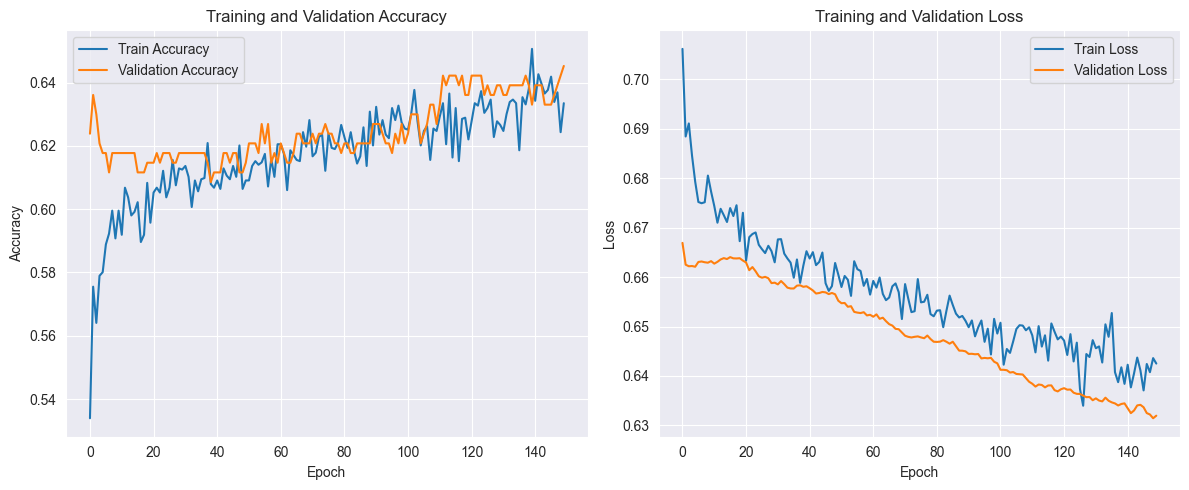

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4658 - loss: 0.7376 - val_accuracy: 0.5076 - val_loss: 0.6932
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5402 - loss: 0.6988 - val_accuracy: 0.5933 - val_loss: 0.6788
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.5600 - loss: 0.6872 - val_accuracy: 0.6147 - val_loss: 0.6714
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5589 - loss: 0.6936 - val_accuracy: 0.6208 - val_loss: 0.6657
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.5775 - loss: 0.6814 - val_accuracy: 0.6147 - val_loss: 0.6633
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5953 - loss: 0.6748 - val_accuracy: 0.6147 - val_loss: 0.6608
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5812 - loss: 0.6786 - val_accuracy: 0.6177 - val_loss: 0.6582
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5781 - loss: 0.6843 - val_accuracy: 0.6177

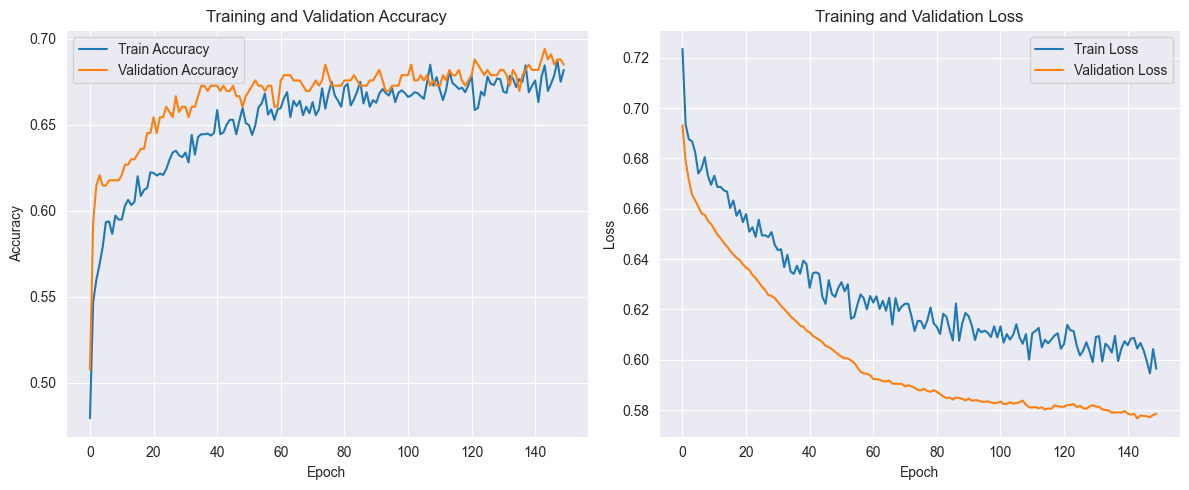

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5228 - loss: 0.6972 - val_accuracy: 0.6116 - val_loss: 0.6767
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5721 - loss: 0.6895 - val_accuracy: 0.6116 - val_loss: 0.6739
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.5906 - loss: 0.6851 - val_accuracy: 0.6147 - val_loss: 0.6720
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6100 - loss: 0.6758 - val_accuracy: 0.6147 - val_loss: 0.6712
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.5765 - loss: 0.6859 - val_accuracy: 0.6147 - val_loss: 0.6706
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5986 - loss: 0.6777 - val_accuracy: 0.6147 - val_loss: 0.6699
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6091 - loss: 0.6741 - val_accuracy: 0.6147 - val_loss: 0.6692
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5945 - loss: 0.6745 - val_accuracy: 0.61

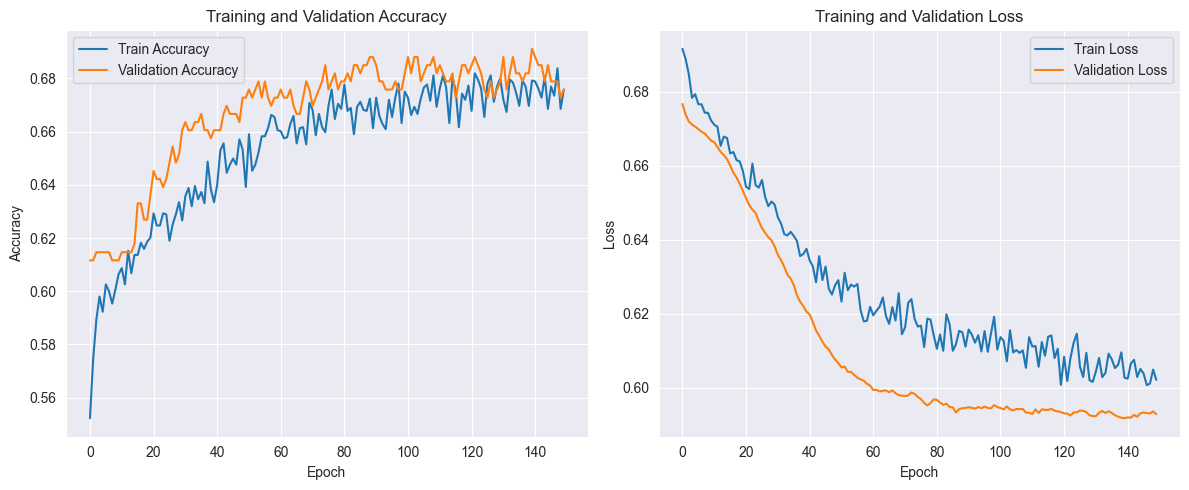

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4447 - loss: 0.7412 - val_accuracy: 0.4832 - val_loss: 0.6997
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5020 - loss: 0.7060 - val_accuracy: 0.6116 - val_loss: 0.6839
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.5219 - loss: 0.7000 - val_accuracy: 0.6208 - val_loss: 0.6772
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.5874 - loss: 0.6786 - val_accuracy: 0.6055 - val_loss: 0.6739
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6156 - loss: 0.6708 - val_accuracy: 0.6086 - val_loss: 0.6713
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5927 - loss: 0.6777 - val_accuracy: 0.6116 - val_loss: 0.6698
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.6014 - loss: 0.6779 - val_accuracy: 0.6116 - val_loss: 0.6682
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5813 - loss: 0.6839 - val_accuracy: 0.61

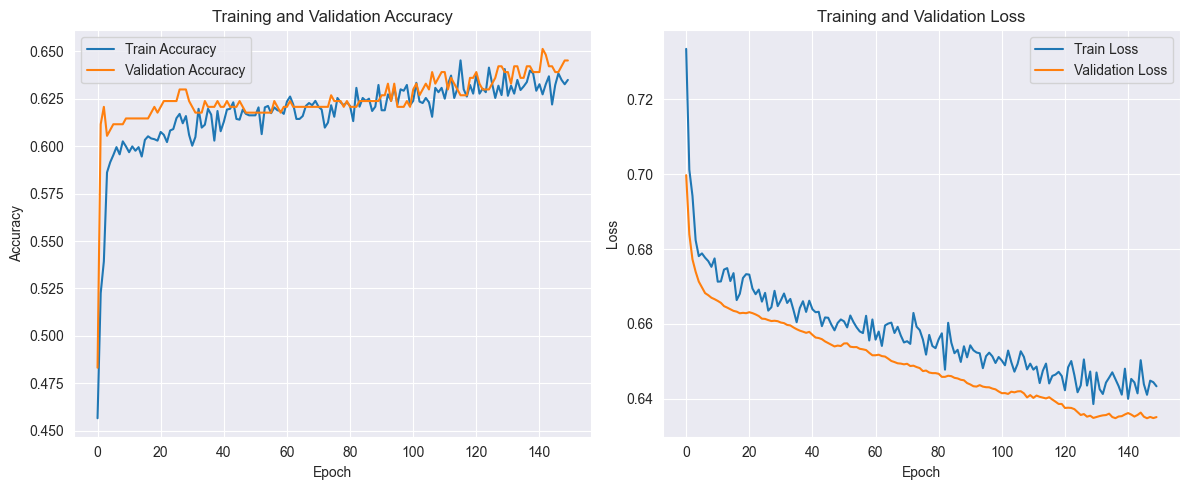

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5266 - loss: 0.7051 - val_accuracy: 0.5841 - val_loss: 0.6759
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5675 - loss: 0.6955 - val_accuracy: 0.5963 - val_loss: 0.6704
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.5810 - loss: 0.6856 - val_accuracy: 0.5994 - val_loss: 0.6658
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.5896 - loss: 0.6800 - val_accuracy: 0.6147 - val_loss: 0.6621
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5818 - loss: 0.6845 - val_accuracy: 0.6177 - val_loss: 0.6595
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6014 - loss: 0.6737 - val_accuracy: 0.6147 - val_loss: 0.6570
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6097 - loss: 0.6684 - val_accuracy: 0.6239 - val_loss: 0.6549
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5885 - loss: 0.6751 - val_accuracy: 0.6

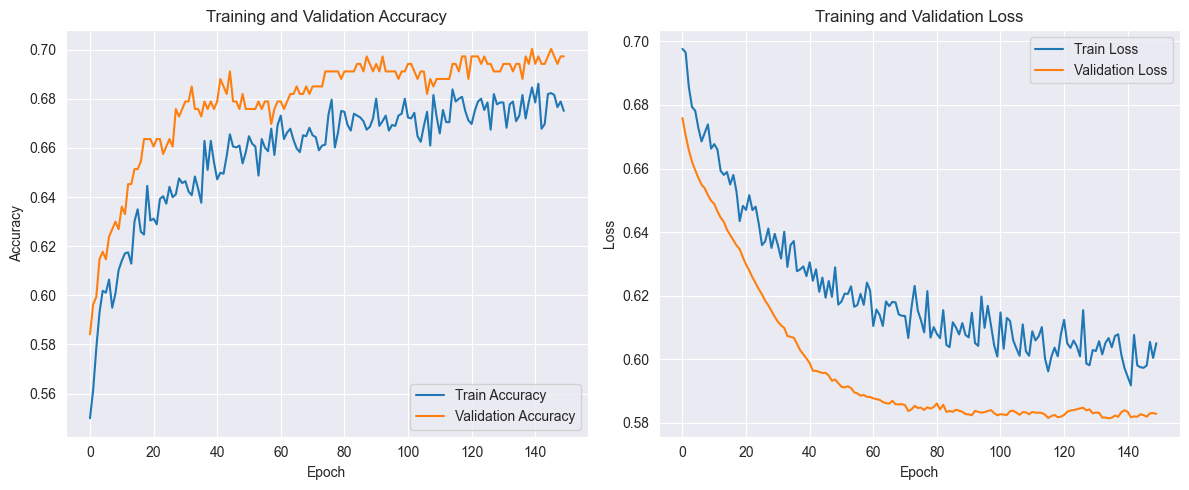

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5406 - loss: 0.6927 - val_accuracy: 0.6147 - val_loss: 0.6782
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5667 - loss: 0.6885 - val_accuracy: 0.6208 - val_loss: 0.6725
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5895 - loss: 0.6821 - val_accuracy: 0.6177 - val_loss: 0.6692
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5921 - loss: 0.6785 - val_accuracy: 0.6269 - val_loss: 0.6654
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6075 - loss: 0.6680 - val_accuracy: 0.6361 - val_loss: 0.6620
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6033 - loss: 0.6722 - val_accuracy: 0.6391 - val_loss: 0.6589
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5808 - loss: 0.6724 - val_accuracy: 0.6391 - val_loss: 0.6564
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 0.6676 - val_accuracy: 0.6361 -

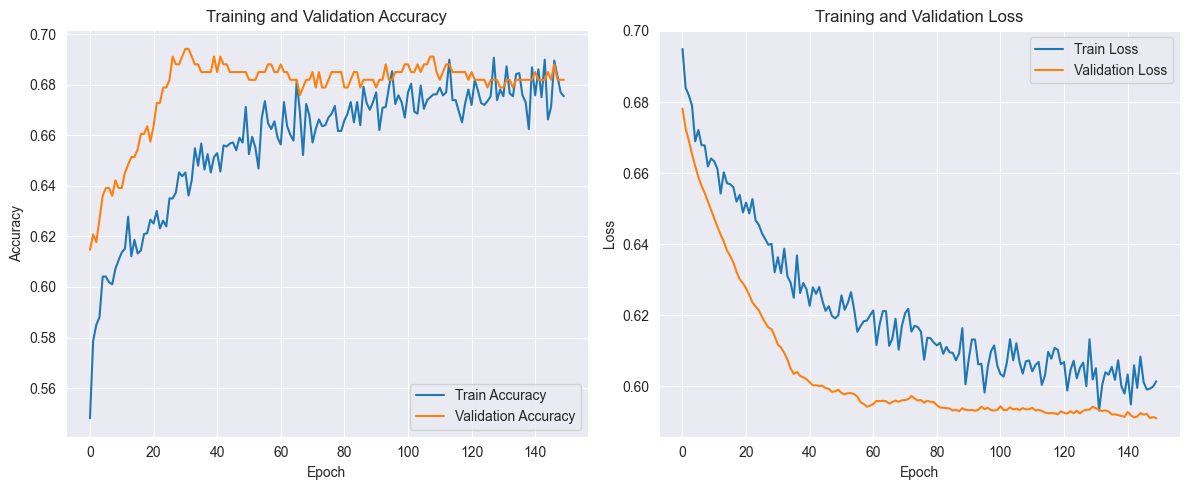

In [72]:
# Std zeros
modelMLP_std_0 = MLPClassifierWrapper(train_std_mlp_0, val_std_mlp_0, test_std_mlp_0)
modelMLP_std_0.train_model()
accuracy_MLP_std_0 = modelMLP_std_0.evaluate_model()
modelMLP_std_0.plot_results()

# Std mean
modelMLP_std_mean = MLPClassifierWrapper(train_std_mlp_mean, val_std_mlp_mean, test_std_mlp_mean)
modelMLP_std_mean.train_model()
accuracy_MLP_std_mean = modelMLP_std_mean.evaluate_model()
modelMLP_std_mean.plot_results()

# Std interpolate
modelMLP_std_interpolate = MLPClassifierWrapper(train_std_mlp_interpolate, val_std_mlp_interpolate, test_std_mlp_interpolate)
modelMLP_std_interpolate.train_model()
accuracy_MLP_std_interpolate = modelMLP_std_interpolate.evaluate_model()
modelMLP_std_interpolate.plot_results()

# Minmax zeros
modelMLP_minmax_0 = MLPClassifierWrapper(train_minmax_mlp_0, val_minmax_mlp_0, test_minmax_mlp_0)
modelMLP_minmax_0.train_model()
accuracy_MLP_minmax_0 = modelMLP_minmax_0.evaluate_model()
modelMLP_minmax_0.plot_results()

# Minmax mean
modelMLP_minmax_mean = MLPClassifierWrapper(train_minmax_mlp_mean, val_minmax_mlp_mean, test_minmax_mlp_mean)
modelMLP_minmax_mean.train_model()
accuracy_MLP_minmax_mean = modelMLP_minmax_mean.evaluate_model()
modelMLP_minmax_mean.plot_results()

# Minmax interpolate
modelMLP_minmax_interpolate = MLPClassifierWrapper(train_minmax_mlp_interpolate, val_minmax_mlp_interpolate, test_minmax_mlp_interpolate)
modelMLP_minmax_interpolate.train_model()
accuracy_MLP_minmax_interpolate = modelMLP_minmax_interpolate.evaluate_model()
modelMLP_minmax_interpolate.plot_results()

## Przedstawienie wyników

In [76]:
results_list = [
    ["SVM", accuracy_SVM_std_0, "Std", "Zeros"],
    ["SVM", accuracy_SVM_std_mean, "Std", "Mean"],
    ["SVM", accuracy_SVM_std_interpolate, "Std", "Interpolate"],
    ["SVM", accuracy_SVM_minmax_0, "Minmax", "Zeros"],
    ["SVM", accuracy_SVM_minmax_mean, "Minmax", "Mean"],
    ["SVM", accuracy_SVM_minmax_interpolate, "Minmax", "Interpolate"],
    ["Random Forest", accuracy_RF_std_0, "Std", "Zeros"],
    ["Random Forest", accuracy_RF_std_mean, "Std", "Mean"],
    ["Random Forest", accuracy_RF_std_interpolate, "Std", "Interpolate"],
    ["Random Forest", accuracy_RF_minmax_0, "Minmax", "Zeros"],
    ["Random Forest", accuracy_RF_minmax_mean, "Minmax", "Mean"],
    ["Random Forest", accuracy_RF_minmax_interpolate, "Minmax", "Interpolate"],
    ["XGBoost", accuracy_XGB_std_0, "Std", "Zeros"],
    ["XGBoost", accuracy_XGB_std_mean, "Std", "Mean"],
    ["XGBoost", accuracy_XGB_std_interpolate, "Std", "Interpolate"],
    ["XGBoost", accuracy_XGB_minmax_0, "Minmax", "Zeros"],
    ["XGBoost", accuracy_XGB_minmax_mean, "Minmax", "Mean"],
    ["XGBoost", accuracy_XGB_minmax_interpolate, "Minmax", "Interpolate"],
    ["MLP", accuracy_MLP_std_0, "Std", "Zeros"],
    ["MLP", accuracy_MLP_std_mean, "Std", "Mean"],
    ["MLP", accuracy_MLP_std_interpolate, "Std", "Interpolate"],
    ["MLP", accuracy_MLP_minmax_0, "Minmax", "Zeros"],
    ["MLP", accuracy_MLP_minmax_mean, "Minmax", "Mean"],
    ["MLP", accuracy_MLP_minmax_interpolate, "Minmax", "Interpolate"],
]

headers = ["Model", "Accuracy", "Normalization", "Missing Data"]

results_df = pd.DataFrame(results_list, columns=headers)

results_df

,Model,Accuracy,Normalization,Missing Data
0,SVM,0.618321,Std,Zeros
1,SVM,0.691603,Std,Mean
2,SVM,0.699237,Std,Interpolate
3,SVM,0.618321,Minmax,Zeros
4,SVM,0.691603,Minmax,Mean
5,SVM,0.699237,Minmax,Interpolate
6,Random Forest,0.673282,Std,Zeros
7,Random Forest,0.682443,Std,Mean
8,Random Forest,0.708397,Std,Interpolate
9,Random Forest,0.673282,Minmax,Zeros
